## Random Forest


In [1]:
from darts import TimeSeries
from darts.models import RandomForest
from darts.utils.statistics import plot_hist
from darts.metrics import mape
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('../../../data/prepared/df_energy_climate_2020.csv')

In [3]:
df = df.drop(['date', 'day_of_week', 'time', 'month'], axis=1)

In [4]:
# Create a TimeSeries, specifying the time and value columns
series = TimeSeries.from_dataframe(df, time_col="datetime", value_cols='energy_price')

splitting_point = (int(len(series)*0.20))

# Set aside the second half of series as a validation series
train, val = series[:-splitting_point], series[-splitting_point:]
# train, val = series.split_before(0.75)

In [5]:
# lag (lagged target values used to predict the next time step)
model = RandomForest(
    lags=168,
    output_chunk_length=168,
    n_estimators=20,
    max_depth=4
)

In [6]:
model.fit(train)

In [7]:
forecast = model.predict(len(val))
print(f'model {model} obtains MAPE: {mape(val, forecast):.2f}%')

model RandomForest(lags={'target': [-168, -167, -166, -165, -164, -163, -162, -161, -160, -159, -158, -157, -156, -155, -154, -153, -152, -151, -150, -149, -148, -147, -146, -145, -144, -143, -142, -141, -140, -139, -138, -137, -136, -135, -134, -133, -132, -131, -130, -129, -128, -127, -126, -125, -124, -123, -122, -121, -120, -119, -118, -117, -116, -115, -114, -113, -112, -111, -110, -109, -108, -107, -106, -105, -104, -103, -102, -101, -100, -99, -98, -97, -96, -95, -94, -93, -92, -91, -90, -89, -88, -87, -86, -85, -84, -83, -82, -81, -80, -79, -78, -77, -76, -75, -74, -73, -72, -71, -70, -69, -68, -67, -66, -65, -64, -63, -62, -61, -60, -59, -58, -57, -56, -55, -54, -53, -52, -51, -50, -49, -48, -47, -46, -45, -44, -43, -42, -41, -40, -39, -38, -37, -36, -35, -34, -33, -32, -31, -30, -29, -28, -27, -26, -25, -24, -23, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1]}, n_estimators=20, max_depth=4) obtains MAPE: 1432.16%


In [8]:
# A 5-tuple containing in order (min target lag, max target lag, min past covariate lag, min future covariate lag, max future covariate lag)
model.extreme_lags

(-168, 168, None, None, None)

## Historical forecasts
Forecasting using historical data.

*Backtesting: General method for seeing how well a model would have done using historical data.

In [9]:
historical_fcast = model.historical_forecasts(
    series,
    start=0.8,
    forecast_horizon=168,
    stride=5,
    overlap_end=False,
    verbose=True
)

  0%|          | 0/319 [00:00<?, ?it/s]

MAPE = 36.67%


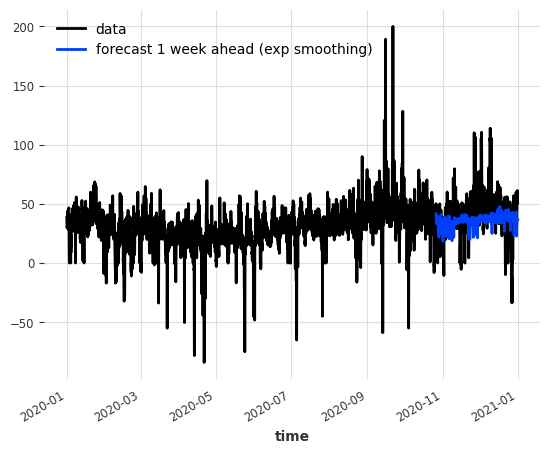

In [10]:
series.plot(label='data')
historical_fcast.plot(label='forecast 1 week ahead (exp smoothing)')
print(f'MAPE = {mape(historical_fcast, series):.2f}%')

## Backtest
It repeatedly builds a training set from the beginning of series. It trains the current model on the training set, emits a forecast of length equal to forecast_horizon, and then moves the end of the training set forward by stride time steps.

In [11]:
raw_errors = model.backtest(
    series,
    start=0.8,
    forecast_horizon=168,
    stride=5,
    reduction=None,
    metric=mape,
    verbose=True
)

  0%|          | 0/319 [00:00<?, ?it/s]

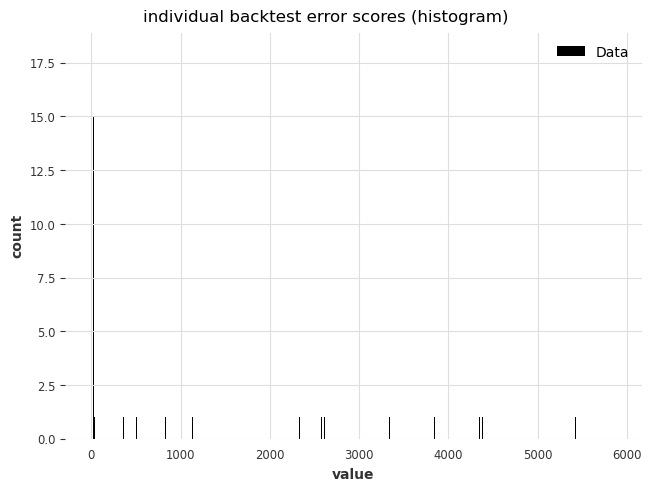

In [12]:
plot_hist(
    raw_errors,
    bins=np.arange(0, max(raw_errors), 1),
    title='individual backtest error scores (histogram)'
)

In [13]:
median_error = model.backtest(
    series,
    start=0.8,
    forecast_horizon=168,
    stride=5,
    reduction=np.median,
    metric=mape,
    verbose=True
)

  0%|          | 0/319 [00:00<?, ?it/s]

In [14]:
print(f'Median error (MAPE) over all historical forecasts: {median_error:.2f}%')

Median error (MAPE) over all historical forecasts: 340.58%


In [15]:
average_error = model.backtest(
    series,
    start=0.8,
    forecast_horizon=168,
    stride=5,
    reduction=np.mean,
    metric=mape,
    verbose=True
)

  0%|          | 0/319 [00:00<?, ?it/s]

In [16]:
print(f'Average error (MAPE) over all historical forecasts: {average_error:.2f}%')

Average error (MAPE) over all historical forecasts: 1380.50%
